---
### Minería de Datos (Máster en Ciencia de Datos)
# Práctica: Intercomparación de técnicas para clasificación
### Rodrigo Manzanas, Ana Casanueva  
#### Departamento de Matemática Aplicada y Ciencias de la Computación (Universidad de Cantabria)
---

## Introducción

En esta práctica haremos una intercomparación de varias de las técnicas vistas hasta ahora para problemas de clasificación: árboles, modelos lineales generalizados (GLMs) y k-NN. Por tanto, pretende ser un repaso general cuyo objetivo es ayudaros a afianzar el manejo de estas técnicas (y los correspondientes paquetes de `R`) para un caso de estudio concreto: la predicción del evento binario ocurrencia de precipitación (lluvia sí/lluvia no).

Comenzaremos cargando el dataset `meteo`, que ya ha sido utilizado en sesiones anteriores. Como sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para predecirla se dispone de 320 predictores que describen la circulación atmosférica de larga escala. Dichos predictores corresponden a un conjunto de  8 variables de larga escala, definidas sobre una malla de 40 puntos (8 en la longitud y 5 en la latitud) que cubre la Península Ibérica.

- Altura geopotencial en 500 hPa (columnas 2:41)
- Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161)
- Temperatura del aire en superficie (columnas 162:201)
- Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281)
- Presión al nivel del mar (columnas 282:321)

In [1]:
## loading data
data = read.csv("/home/rodrigo/work/DOCENCIA/2024-2025/M1966_mineria_datos_data_science/S11_IntercomparisonClassificationTechniques/data/meteo.csv")
y = data[, 2]  # predictand
x = data[, -c(1,2)]  # predictors
length(y)
dim(x)
rm(data)

[1] 10958

[1] 10958   320

Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad de nuestro problema. Una alternativa para tal fin es el uso de componentes principales (PCs, en inglés). Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La idea es que, cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Este análisis nos permite descartar predictores poco relevantes.
Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

[1] 37

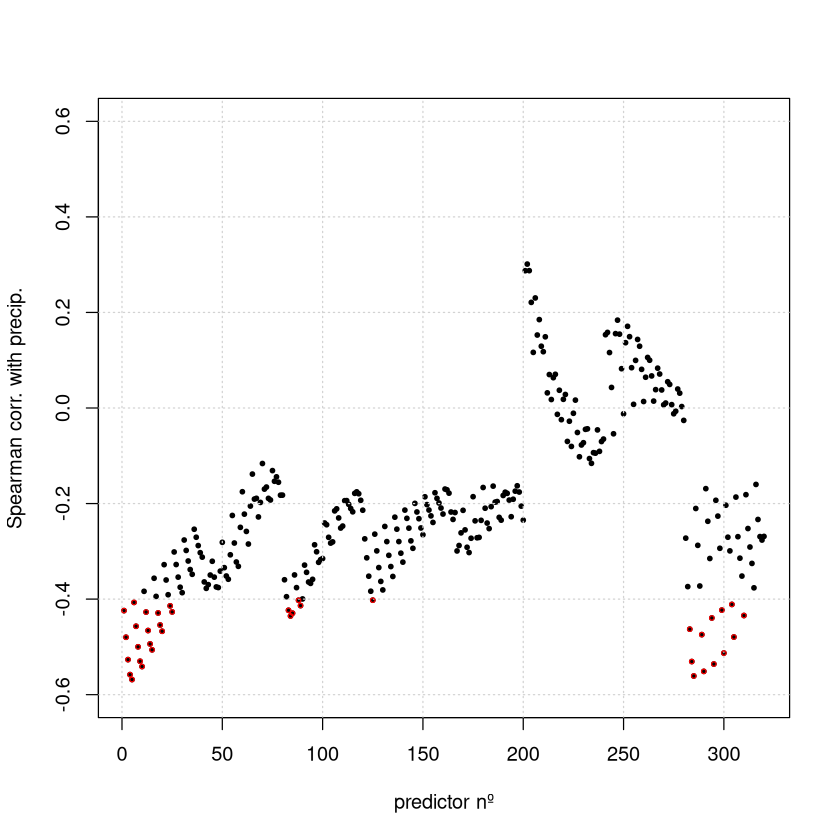

In [2]:
## informed selection of predictors, based on a correlation analysis
r.xy = rep(NA, 320)
for (ivar in 1:ncol(x)) {
  r.xy[ivar] = cor(y, x[, ivar], method = "spearman")
}
plot(r.xy, ylim = c(-0.6, 0.6), pch = 19, cex = 0.5, 
     xlab = "predictor nº", ylab = "Spearman corr. with precip.")
grid()

ind.sele = which(abs(r.xy) > 0.4)
points(ind.sele, r.xy[ind.sele], col = "red", cex = 0.5)
length(ind.sele)  # retaining only 37 predictors out of 320

Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como hemos hecho otras veces, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para testear).

In [3]:
# keeping only 5000 days for this example
n = 5000
y = y[1:n]
x = x[1:n, ind.sele]

# train/test partition
set.seed(0)
indtrain = sample(1:n, round(0.75*n))  
indtest = setdiff(1:n, indtrain)

## Árboles de clasificación

En primer lugar, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1mm). A partir de esta nueva variable (*occ*), de tipo factor, construiremos el dataframe asociado al problema.

In [4]:
# binary occurrence
occ = as.factor(ifelse(y > 1, 1, 0))  # dry/wet days

# dataframe for occurrence
df.occ = data.frame(y.occ = occ, predictors = x)

A continuación construiremos el árbol **completo**, es decir, aquel que da lugar a un error *cero* en el train (usa para ello la función *tree*). ¿Cuántos nodos terminales (hojas) obtienes? ¿Qué variables predictoras dan lugar a las primeras divisiones del árbol?


Classification tree:
tree(formula = y.occ ~ ., data = df.occ, subset = indtrain, mincut = 1, 
    minsize = 2, mindev = 0)
Variables actually used in tree construction:
 [1] "predictors.X285" "predictors.X284" "predictors.X19"  "predictors.X83" 
 [5] "predictors.X84"  "predictors.X5"   "predictors.X1"   "predictors.X304"
 [9] "predictors.X25"  "predictors.X24"  "predictors.X10"  "predictors.X9"  
[13] "predictors.X125" "predictors.X3"   "predictors.X4"   "predictors.X283"
[17] "predictors.X88"  "predictors.X18"  "predictors.X294" "predictors.X290"
[21] "predictors.X12"  "predictors.X6"   "predictors.X13"  "predictors.X85" 
[25] "predictors.X289" "predictors.X310" "predictors.X15"  "predictors.X295"
[29] "predictors.X14"  "predictors.X2"   "predictors.X7"   "predictors.X8"  
[33] "predictors.X299" "predictors.X305" "predictors.X300"
Number of terminal nodes:  284 
Residual mean deviance:  0 = 0 / 3466 
Misclassification error rate: 0 = 0 / 3750 

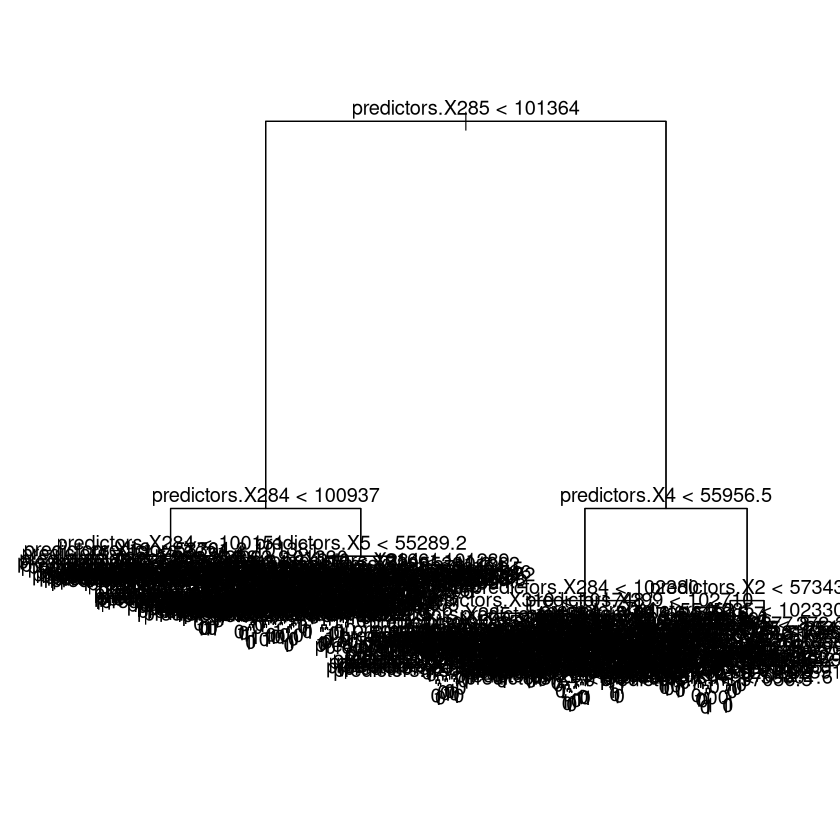

In [5]:
## complete tree (based on training dataset)
library(tree)
t.occ = tree(y.occ ~., df.occ, subset = indtrain,
     mincut = 1, minsize = 2, mindev = 0)
plot(t.occ); text(t.occ, pretty = F)
summary(t.occ)

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente (*prune.tree*). Utiliza una cross-validación con un 10-fold (*cv.tree*) para encontrar el número de hojas del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

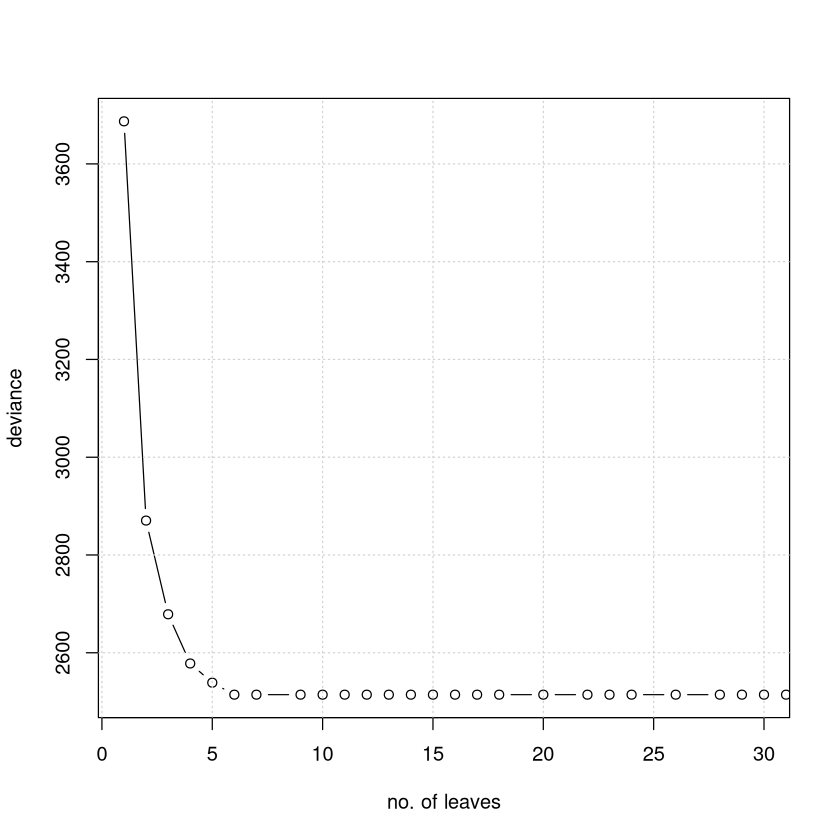

In [6]:
## 10-fold cross-validation for determining optimum number of leaves
t.occ.cv = cv.tree(t.occ, K = 10)
plot(t.occ.cv$size, t.occ.cv$dev, type = "b", xlim = c(1, 30), 
    xlab = "no. of leaves", ylab = "deviance")  # deviance as a function of number of leaves
grid()


Classification tree:
snip.tree(tree = t.occ, nodes = c(11L, 4L, 10L, 6L, 14L))
Variables actually used in tree construction:
[1] "predictors.X285" "predictors.X284" "predictors.X5"   "predictors.X4"  
[5] "predictors.X2"  
Number of terminal nodes:  6 
Residual mean deviance:  0.6383 = 2390 / 3744 
Misclassification error rate: 0.1373 = 515 / 3750 

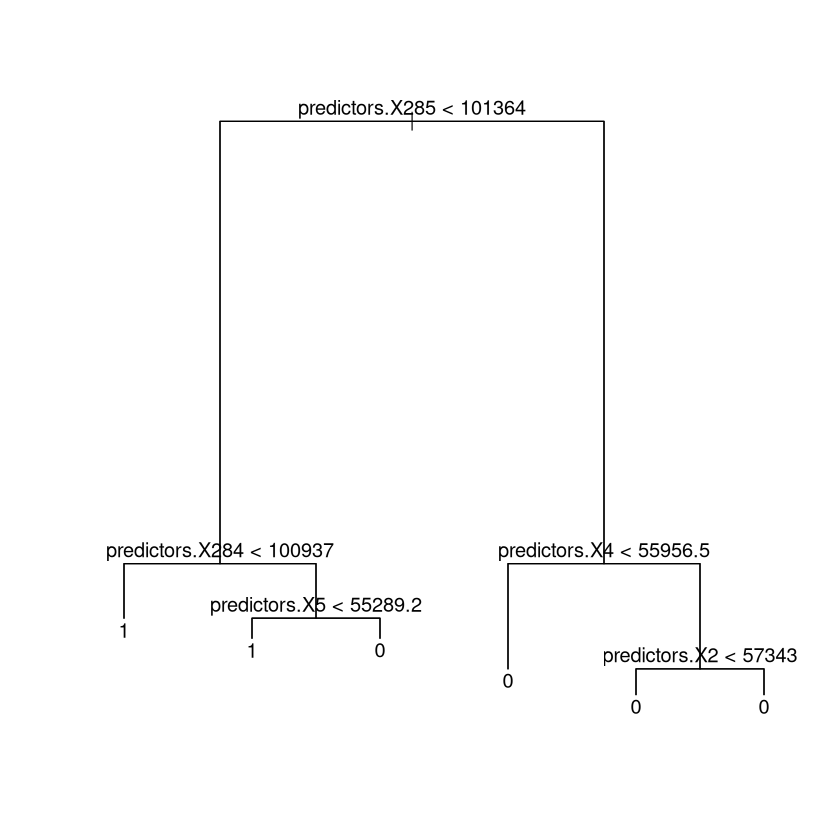

In [7]:
## pruning
t.occ.opt = prune.tree(t.occ, best = 6)
plot(t.occ.opt); text(t.occ.opt)
summary(t.occ.opt)

A la vista de la representación gráfica del árbol, ya sabes cuál será la profundidad (número de niveles verticales = número de ramas que se producen desde el nodo raíz hasta la hoja más profunda del árbol) óptima. Utiliza el paquete *rpart* para entrenar un árbol con esa profundidad, represéntalo (*rpart.plot*) y comprueba si hay diferencias.

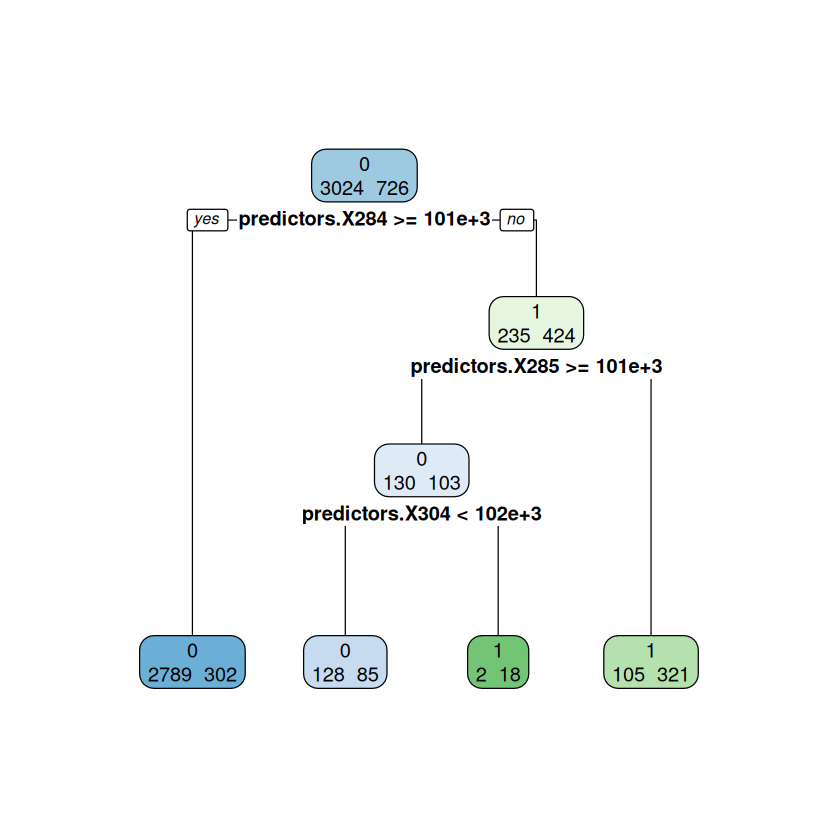

In [8]:
library(rpart)
t.occ.opt2 = rpart(y.occ ~., df.occ, subset = indtrain, 
               maxdepth = 3)
library(rpart.plot)
rpart.plot(t.occ.opt2, extra = 1)

Utiliza los dos árboles para predecir en el test.

 Factor w/ 2 levels "0","1": 1 2 1 1 1 1 2 2 2 2 ...
 Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 2 2 2 ...
 - attr(*, "names")= chr [1:1250] "2" "5" "6" "8" ...


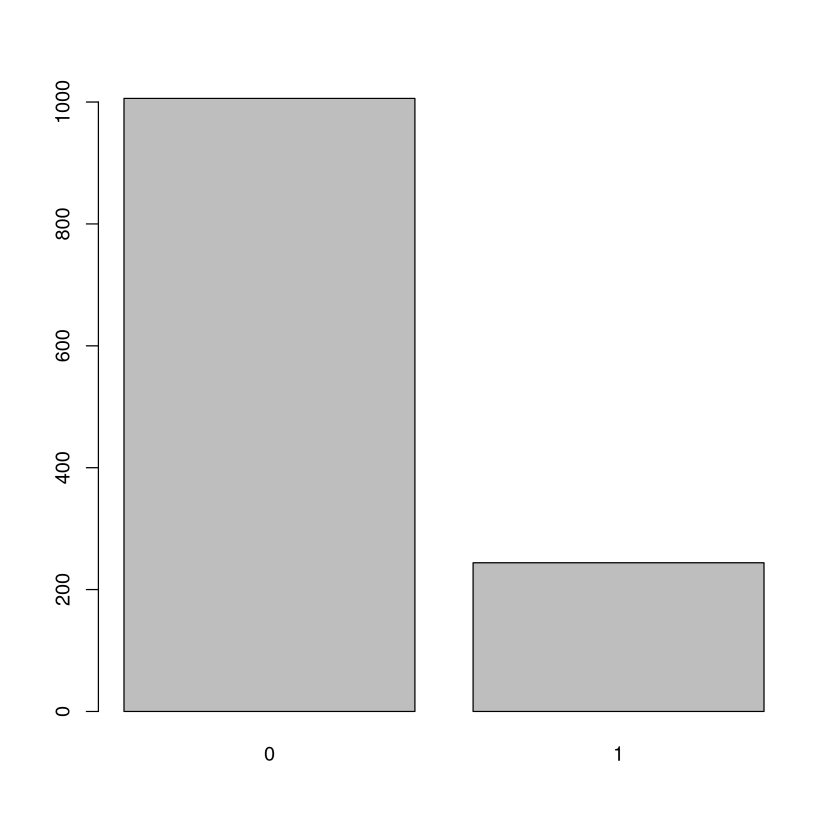

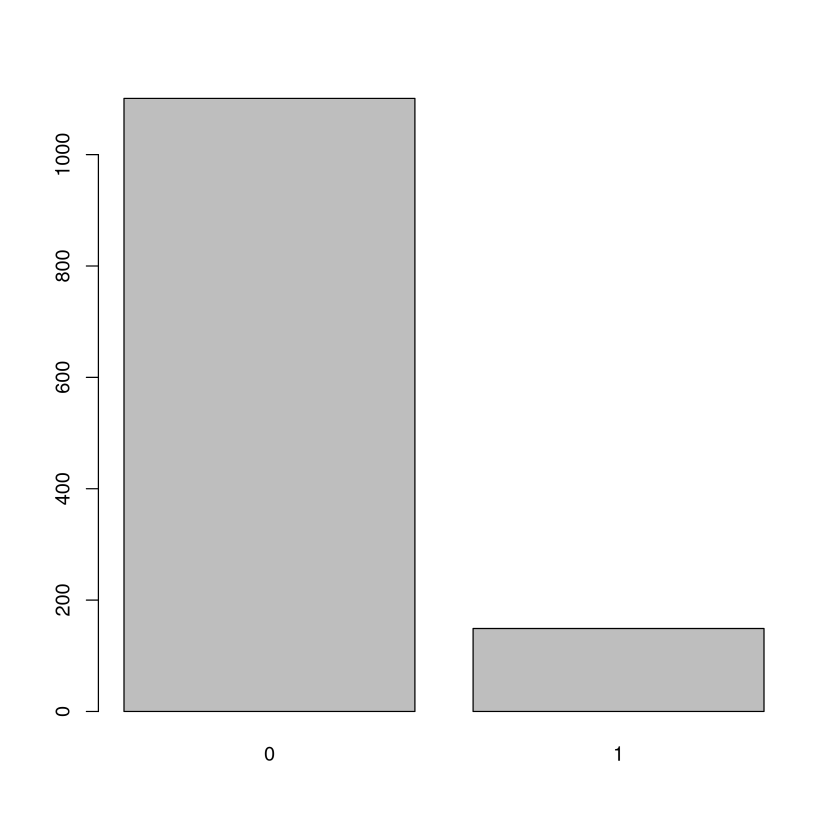

In [9]:
## occurrence prediction for test
# tree fitted with 'tree'
pred.t.occ = predict(t.occ.opt, df.occ[indtest, ], type = "class")
str(pred.t.occ)
plot(pred.t.occ)

# tree fitted with 'rpart'
pred.t.occ2 = predict(t.occ.opt2, df.occ[indtest, ], type = "class")
str(pred.t.occ2)
plot(pred.t.occ2)

Valida tus predicciones en función del accuracy (tasa de ciertos) y la correlación de Spearman. Esta última nos dará una idea de lo bien/mal que la predicción reproduce la estructura temporal de la serie observada.

In [10]:
## validation
# accuracy 
acc.t = sum(diag(table(occ[indtest], pred.t.occ))) / length(indtest)
acc.t2 = sum(diag(table(occ[indtest], pred.t.occ2))) / length(indtest)
c(acc.t, acc.t2)

# correlation
cor.t = cor(as.numeric(occ[indtest]), as.numeric(pred.t.occ), method = "spearman")
cor.t2 = cor(as.numeric(occ[indtest]), as.numeric(pred.t.occ2), method = "spearman")
c(cor.t, cor.t2)

[1] 0.8544 0.8632

[1] 0.5438458 0.5259871

Como último ejercicio con árboles, utiliza esta vez *caret* para determinar la profundidad óptima del árbol. Para ello, barre profundidades de 1 a 20 considerando una cross-validación 10-fold que repetirás 20 veces. A continuación, construye un árbol que tenga esa profundidad que has encontrado como óptima (*rpart*) y utilízalo para predecir en el test. Valida las predicciones que obtengas en función del accuracy y la correlación y compara los resultados con los que habías obtenido anteriormente.

Loading required package: ggplot2

Loading required package: lattice



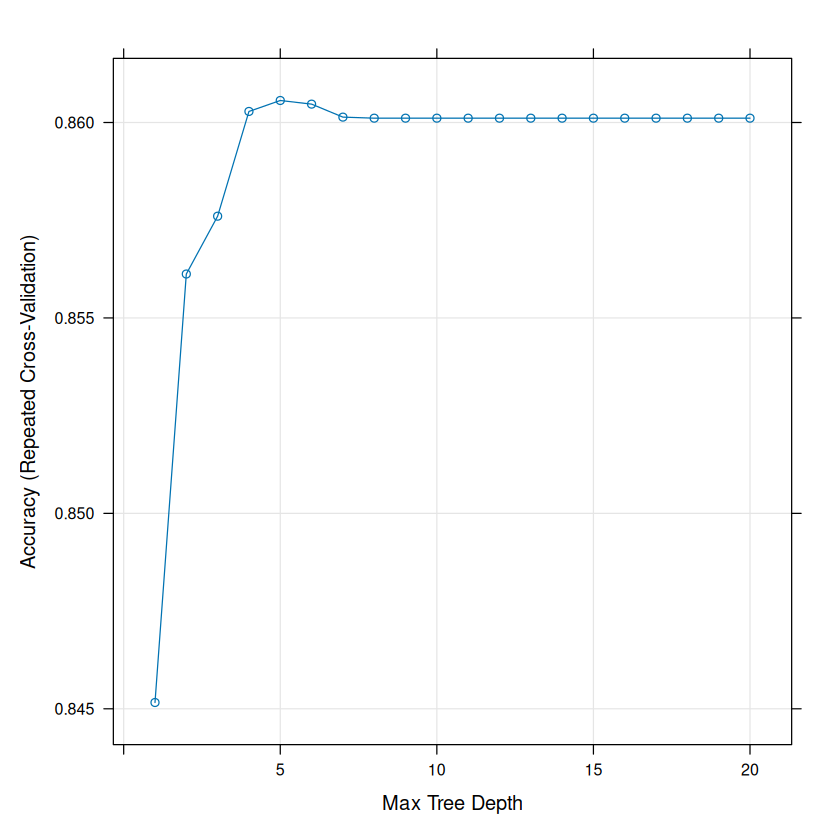

In [11]:
library(caret)
## finding optimum depth
trctrl = trainControl(method = "repeatedcv", repeats = 20, number = 10)
t.opt = train(y.occ ~ ., df.occ, subset = indtrain,
                method = "rpart2",
                trControl = trctrl,                
                tuneGrid = expand.grid(maxdepth = 1:20))
plot(t.opt)

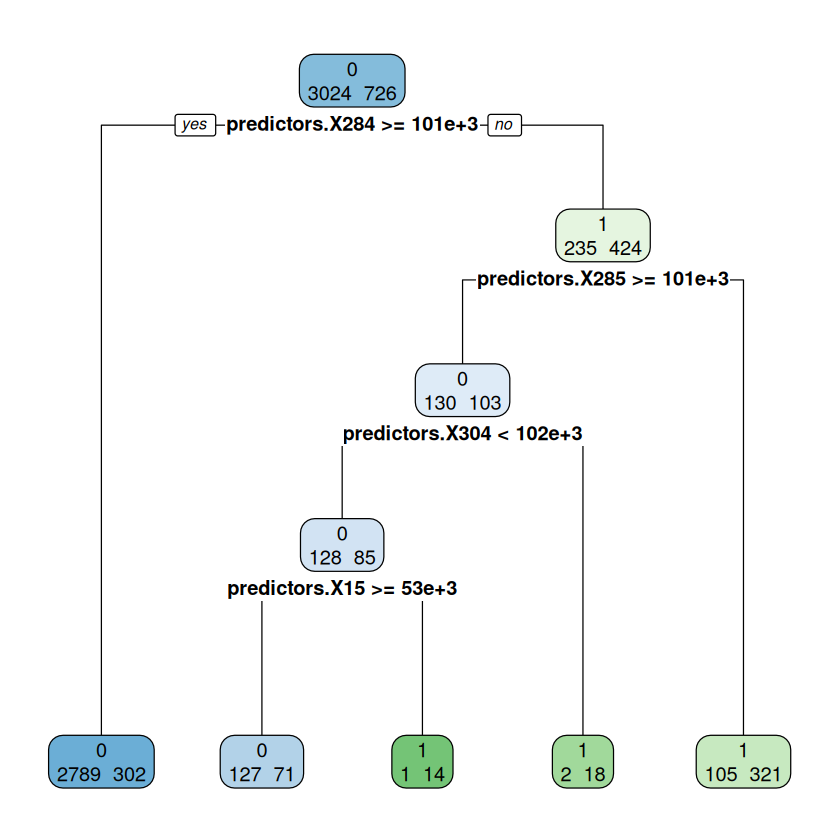

In [12]:
## building tree up
t.occ.opt3 = rpart(y.occ ~., df.occ, subset = indtrain, 
              maxdepth = 6)
rpart.plot(t.occ.opt3, extra = 1)

In [13]:
## occurrence prediction for test
# tree fitted with 'rpart' (based on optimum configuration returned by caret)
pred.t.occ3 = predict(t.occ.opt3, df.occ[indtest, ], type = "class")

## validation
# accuracy 
acc.t3 = sum(diag(table(occ[indtest], pred.t.occ3))) / length(indtest)

# correlation
cor.t3 = cor(as.numeric(occ[indtest]), as.numeric(pred.t.occ3), method = "spearman")
c(acc.t3, cor.t3)

[1] 0.8640000 0.5305583

## Modelos lineales generalizados (GLMs)

Usaremos a continuación GLMs para el mismo problema. Dado que nuestra variable objetivo es binaria, utilizaremos la familia *binomial* con función de enlace *logit* (regresión logística) dentro de la función *glm* del paquete *stats*.

Comenzamos hallando los coeficientes del ajuste en el train. Recuerda que en este tipo de modelos es conveniente que los predictores estén estandarizados, pues se mejora con ello su estabilidad.

In [14]:
## GLM for occurrence
x.train = df.occ[indtrain, -1]
x.test = df.occ[indtest, -1]
params.scaling = preProcess(x.train, method = c("center", "scale"))
x.train.scaled = scale(x.train, 
                       center = params.scaling$mean, 
                       scale = params.scaling$std)
x.test.scaled = scale(x.test, 
                       center = params.scaling$mean, 
                       scale = params.scaling$std)
df.train.scaled = data.frame(y.occ = df.occ$y.occ[indtrain], x.train.scaled)
df.test.scaled = data.frame(y.occ = df.occ$y.occ[indtest], x.test.scaled)

glm.occ = glm(y.occ ~ ., df.train.scaled, family = binomial(link = "logit"))

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera para ello un umbral 0.5). Valida tus resultados en función del accuracy y la correlación.

 Named num [1:1250] 0.201 0.676 0.309 0.109 0.164 ...
 - attr(*, "names")= chr [1:1250] "2" "5" "6" "8" ...
 Named num [1:1250] 0 1 0 0 0 0 0 1 1 1 ...
 - attr(*, "names")= chr [1:1250] "2" "5" "6" "8" ...


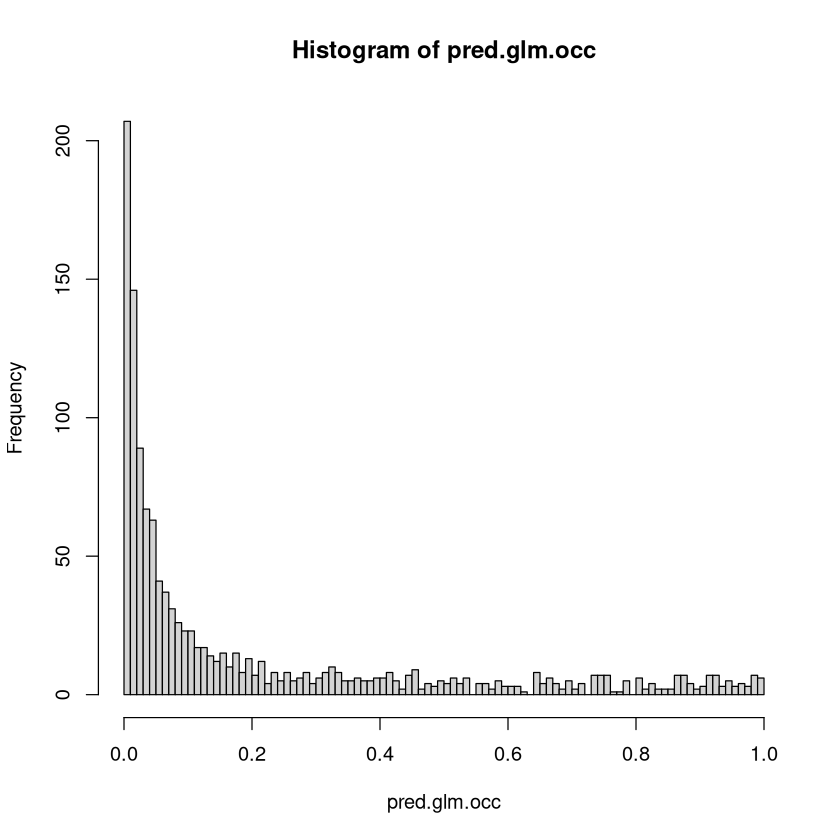

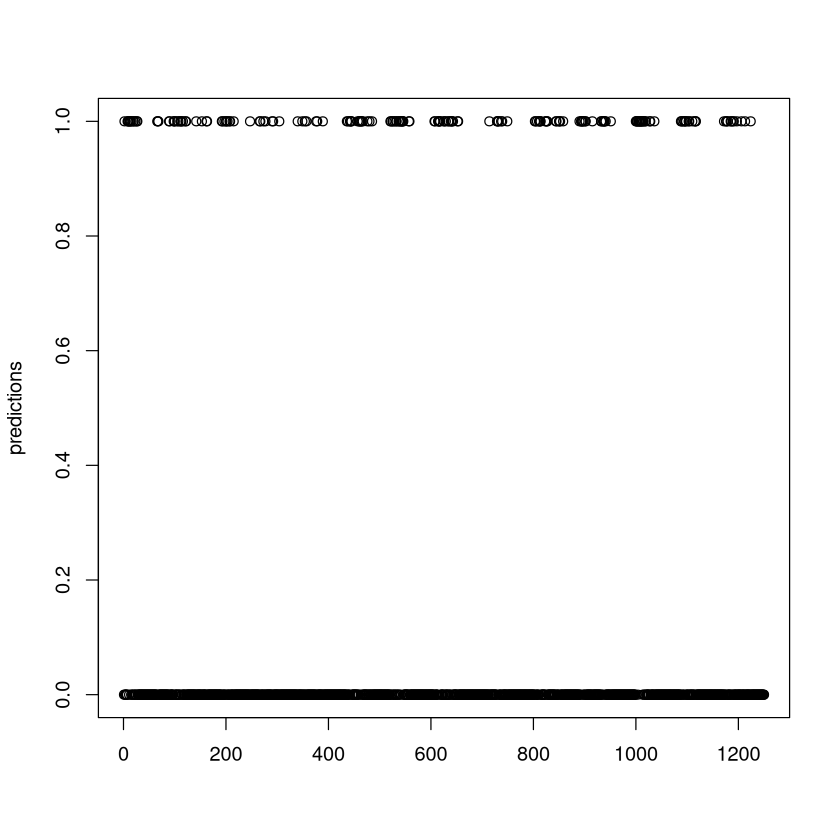

In [23]:
## occurrence prediction for test
pred.glm.occ = predict(glm.occ, df.test.scaled, type = "response")
str(pred.glm.occ)
hist(pred.glm.occ, 100)
pred.glm.occ = ifelse(pred.glm.occ >= 0.5, 1, 0)
str(pred.glm.occ)
plot(pred.glm.occ, xlab = "", ylab = "predictions")

In [16]:
## validation
# accuracy
acc.glm = sum(diag(table(occ[indtest], pred.glm.occ))) / length(indtest)

# correlation
cor.glm = cor(as.numeric(occ[indtest]), as.numeric(pred.glm.occ), method = "spearman")

c(acc.glm, cor.glm)

[1] 0.8704000 0.5687262

A continuación, entrena otros dos GLMs, uno que considere como único predictor una de las variables con mayor poder explicativo y otro que utilice como único predictor cualquier otra variable. Básate en los árboles para hacer estas elecciones. Utiliza ambos GLMs para predecir en el test y valida tus predicciones en función del accuracy y la correlación. ¿Qué conclusiones obtienes?

In [17]:
# GLM for occurrence (one good predictor)
glm.occ2 = glm(y.occ ~ predictors.X285,
              df.train.scaled, family = binomial(link = "logit"))
pred.glm.occ2 = predict(glm.occ2, df.test.scaled, type = "response")
pred.glm.occ2 = ifelse(pred.glm.occ2 >= 0.5, 1, 0)
acc.glm2 = sum(diag(table(occ[indtest], pred.glm.occ2))) / length(indtest)
cor.glm2 = cor(as.numeric(occ[indtest]), as.numeric(pred.glm.occ2), method = "spearman")
c(acc.glm2, cor.glm2)

# GLM for occurrence (one random predictor)
glm.occ3 = glm(y.occ ~ predictors.X125,
              df.train.scaled, subset = indtrain, family = binomial(link = "logit"))
pred.glm.occ3 = predict(glm.occ3, df.test.scaled, type = "response")
pred.glm.occ3 = ifelse(pred.glm.occ3 >= 0.5, 1, 0)
acc.glm3 = sum(diag(table(occ[indtest], pred.glm.occ3))) / length(indtest)
cor.glm3 = cor(as.numeric(occ[indtest]), as.numeric(pred.glm.occ3), method = "spearman")
c(acc.glm3, cor.glm3)

[1] 0.8600000 0.5101783

[1] 0.801600 0.228531

## k nearest neighbors (k-NN)

La última de las técnicas a utilizar será la k-NN. Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función *knn* del paquete *class*). Valida tus predicciones en el test en función del accuracy y la correlación.

**Nota:** Recuerda que en la técnica k-NN es importante que los predictores estén debidamente estandarizados.

In [18]:
## prediction for test (with k = 1)
library(class)
pred.knn1 = knn(train = x.train.scaled, 
                   test = x.test.scaled, 
                   cl = df.occ[indtrain, 1],
                   k = 1)
str(pred.knn1)

## validation
acc.knn1 = sum(diag(table(occ[indtest], pred.knn1))) / length(indtest)
cor.knn1 = cor(as.numeric(occ[indtest]), as.numeric(pred.knn1), method = "spearman")
c(acc.knn1, cor.knn1)

 Factor w/ 2 levels "0","1": 1 1 2 2 1 2 1 2 2 2 ...


[1] 0.836000 0.478138

El único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete *caret* para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train barriendo todos los k impares desde 1 a 50.

    k
14 27


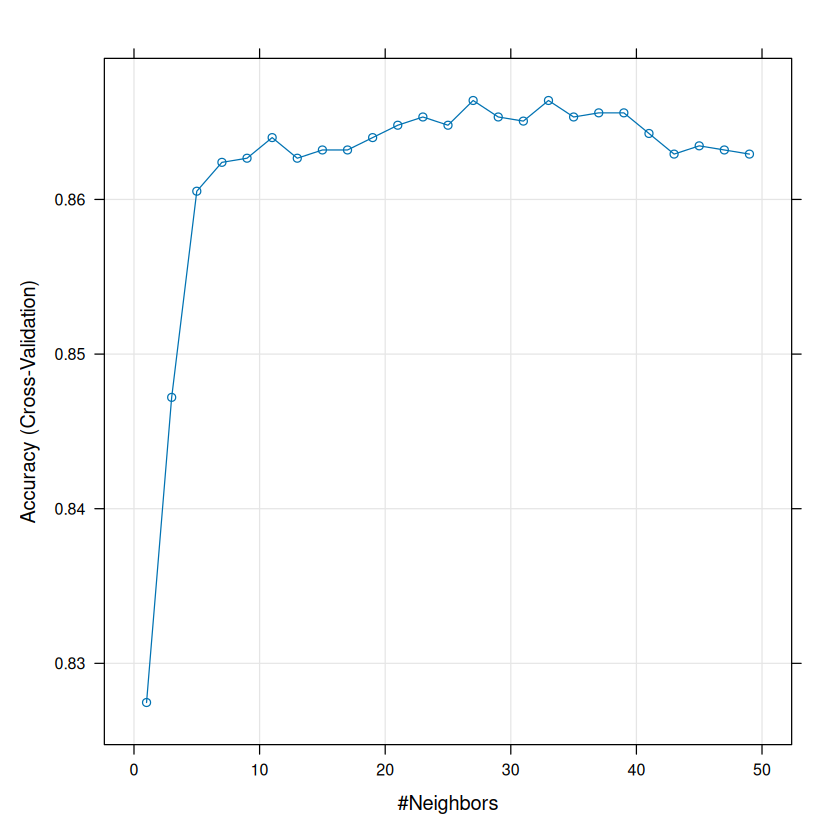

In [19]:
library(caret)
## finding optimum k
trctrl = trainControl(method = "cv", number = 10)
knn.opt = train(y.occ ~ ., df.occ, subset = indtrain,
                method = "knn",
                trControl = trctrl,
                preProcess = c("center", "scale"),
                tuneGrid = expand.grid(k = seq(1, 50, 2)))
plot(knn.opt)
print(knn.opt$bestTune)

Utiliza este *k* óptimo para predecir en el test y valida tus resultados en función de la accuracy y la correlación.

In [20]:
# prediction for test (with optimum k)
pred.knn.opt = knn(train = x.train.scaled, 
                   test = x.test.scaled, 
                   cl = df.occ[indtrain, 1],
                   k = 15)
str(pred.knn.opt)

 Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 2 2 2 ...


In [21]:
## validation
acc.knn.opt = sum(diag(table(occ[indtest], pred.knn.opt))) / length(indtest)
cor.knn.opt = cor(as.numeric(occ[indtest]), as.numeric(pred.knn.opt), method = "spearman")
print(c(acc.knn.opt, cor.knn.opt))

[1] 0.8672000 0.5525177
